# Calculate bull and bear markets
Adapted from https://stackoverflow.com/questions/64830383/calculating-bull-bear-markets-in-pandas

In [1]:
# Ensure data is available
!make modeldata

python get_data.py
python clean_data.py


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_orig = pd.read_csv('clean_data/multpl_clean.csv', index_col = 0, parse_dates=True)

In [3]:
df_orig.columns

Index(['S&P500 Price', 'S&P500 Price - Inflation Adjusted',
       'S&P500 Dividend Yield', 'S&P500 PE ratio', 'S&P500 Earnings',
       'S&P500 Earnings Yield', 'Shiller PE Ratio',
       'case Shiller Home Price Index', 'Inflation Rate'],
      dtype='object')

In [4]:
def calculate_bear_market(indf, price_col, include_corrections=True):
    '''
    Calculate a bear market.
    Adapted from https://stackoverflow.com/questions/64830383/calculating-bull-bear-markets-in-pandas
    I've added comments as I've reverse engineered it
    '''
    # avoid directly modifying the df (in case that's not desired)
    df = indf.copy()

    # get the % drawdown from the high up to that point ( cummax() )
    # this number is negative if lower or 0 if new high
    df['dd'] = df[price_col].div(df[price_col].cummax()).sub(1)

    # if current reading is immediately lower after a new high, add a new group number (ddn)
    df['ddn'] = ((df['dd'] < 0.) & (df['dd'].shift() == 0.)).cumsum()

    # get the largest drawdown for the group.  e.g. market bottom
    df['ddmax'] = df.groupby('ddn')['dd'].transform('min')

    # determine if this is a bear market if both conditions are true:
    ## max drawdown for a given period is over 20% AND
    ## cumulative drawdown hasn't hit the bottom yet
    df['bear'] = (df['ddmax'] < -0.2) & (df['ddmax'] < df.groupby('ddn')['dd'].transform('cummin'))
    
    # group bear markets into start/end periods (min/max dates)
    df['bearn'] = ((df['bear'] == True) & (df['bear'].shift() == False)).cumsum()

    # calculate the start and end dates of the bear market
    bears = df.reset_index().query('bear == True').groupby('bearn')['Date'].agg(['min', 'max'])

    # let's also consider corrections
    corrections = None
    if include_corrections:
        df['correction'] = (~df['bear']) & (df['ddmax'] < -0.1) & (df['ddmax'] < df.groupby('ddn')['dd'].transform('cummin'))
        df['corrn'] = ((df['correction'] == True) & (df['correction'].shift() == False)).cumsum()
        corrections = df.reset_index().query('correction == True').groupby('corrn')['Date'].agg(['min', 'max'])
        df = df.drop(columns=['corrn'])

    '''
    Now that we've identified if we're in a bear market, ignore the following features as they 
    are not relevant for training:
    period numbering:  ddn, bearn
    only meaninful during a bear market: ddmax
    It might be meaningful to keep ddn and use either bear or correction as possible targets.
    '''    
    df = df.drop(columns=['ddn','bearn','ddmax']), bears, corrections
    
    return df


In [5]:
# Not sure if we should use  actual or inflation adjusted price.  Inflation adjusted seems better but more experimentation could be useful.
#price_col = 'S&P500 Price'
price_col = 'S&P500 Price - Inflation Adjusted'
d2, bears, corrections = calculate_bear_market(df_orig, price_col)
d2


,S&P500 Price,S&P500 Price - Inflation Adjusted,S&P500 Dividend Yield,S&P500 PE ratio,S&P500 Earnings,S&P500 Earnings Yield,Shiller PE Ratio,case Shiller Home Price Index,Inflation Rate,dd,bear,correction
Date,,,,,,,,,,,,
1871-01-01,4.44,109.41,NaN,11.10,NaN,9.01,NaN,NaN,NaN,0.000000,False,False
1871-02-01,4.50,107.61,NaN,11.25,NaN,8.89,10.92,NaN,NaN,-0.016452,False,False
1871-03-01,4.61,108.63,NaN,11.52,NaN,8.68,11.19,NaN,NaN,-0.007129,False,False
1871-04-01,4.74,115.88,NaN,11.85,NaN,8.44,12.05,NaN,NaN,0.000000,False,False
1871-05-01,4.86,121.62,NaN,12.15,NaN,8.23,12.59,NaN,NaN,0.000000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,4409.10,4398.52,NaN,23.93,NaN,4.18,29.80,NaN,3.70,-0.146927,False,False
2023-10-01,4269.40,4260.80,NaN,23.17,NaN,4.32,28.77,NaN,3.24,-0.173637,False,False
2023-11-01,4460.06,4460.06,NaN,24.21,NaN,4.13,30.08,NaN,3.14,-0.134992,False,False


In [6]:
total = d2.shape[0]
bear_months = d2[d2['bear']].shape[0]
corr_months = d2[d2['correction']].shape[0]

print('bearish months %: ', round(bear_months/total*100,2))
print('correction months %: ', round(corr_months/total*100,2))

bearish months %:  34.13
correction months %:  3.32


In [7]:
# Adapted from https://stackoverflow.com/questions/64830383/calculating-bull-bear-markets-in-pandas
def gen_chart(start = None, end = None):
  df = df_orig.copy()
  
  if start:
    df = df[df.index>start] 
  if end:
    df = df[df.index<end] 

  df, bears, corrections = calculate_bear_market(df, price_col)

  #df.index = df.index.astype('float64')
  from datetime import date

  events = bears
  #events = corrections

  # plot
  df[price_col].plot()

  for i in range(events.shape[0]):
    plt.axvspan(xmin = events.iloc[i]['min'], xmax = events.iloc[i]['max'], alpha = 0.25, color = 'grey')

  #for i, row in dates.iterrows():
  #    plt.fill_between(row, df[price_col].max(), alpha=0.25, color='r')
  plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
  plt.ylabel('S&P 500 Index')
  plt.title('S&P 500 Index with Bear Markets (> 20% Declines)')

  #plt.savefig('bears.png')
  plt.show()

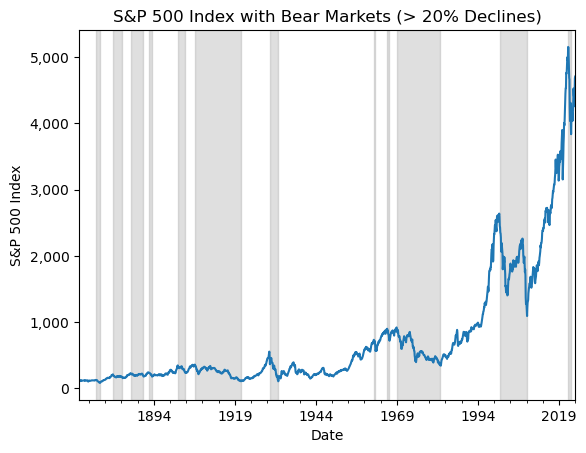

In [8]:
gen_chart()

### Exploration
One challenge we'll need to explore more is when to call a bear market over.  Current usage has it as lowest low since highest high.  This seems naive.  Here's why:

In the range 1994-01-01 to 2008-09-01, we see a bear market ending around 2003.

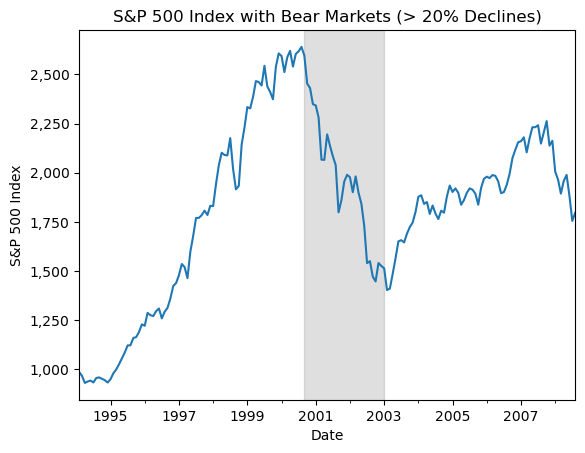

In [9]:
gen_chart(start = '1994-01-01', end = '2008-09-01')

However, if we extend out the timeframe to Sept 2010, then the bear market extends to 2009.  I suppose this is where the "secular bull market" argument comes in.  We'll have to consider if we want to wade into that argument or not.

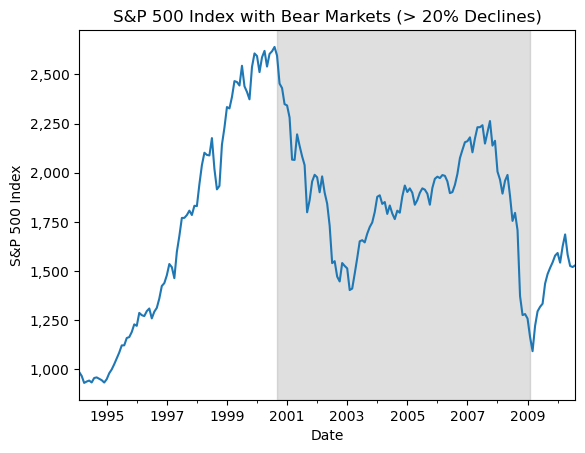

In [10]:
gen_chart(start = '1994-01-01', end = '2010-09-01')